<img src="../code/cropped-SummerWorkshop_Header.png"> 

<h1 align="center">Workshop 2: What is a behavior state?</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Thursday, August 24th, 2023</h3> 
<h4 align="center">Day 4 team</h4> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Notebook outline and objectives </h2>
    
<p>In W1 we manually clustered/identified behavioral states. Our goal in this workshop 2 will be to ask the question whether we can do this more automatically, and to describe some computational tools for doing this.
    
<l1>We would introduce unsupervised mixture model
What is a mixture model? How do we fit it?
<l1>Then we’d talk about additional constraints on model
E.g. what is the timescale of state transitions?
<l1>Introduction to state-space models
<l1>Hidden Markov Model
<l1>Applying HMM to VB example session
    
<p>This notebook will show you how to extract behavioral states from data using dynamax as a versitile software toolkit.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
<p>Let's take a moment to import our minmal set of packages
    
<ul> Dynamax is a package created in collaboration between the Linderman lab and Google building around a JAX engine. JAX is a functional language which handles the backend for fast computation while presenting similarly to numpy.
<p> ipywidgets allows us to display progress bars used in Dynamax (specially the tqdm package)    

</div>

In [22]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax
    
import warnings
warnings.filterwarnings("ignore")

In [2]:
%pip install -q ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange
import optax

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> K-means and Gaussian Mixture Models</h2>
    
<p> First, lets sort out our notations: 
<br> <b> Constants and data </b> 
<br> $N$ - number of data points. 
<br> $K$ - number of clusters/components
<br> $x_{n} \in R^{D}$ - $n^{th}$ input data point
<br> $z_{n} \in \{1, ..., K\}$ - cluster/component assignment for $n^{th}$ data point
<br> <b> Model parameters</b>   
<br> $\theta_{k}$ - parameters of the $k^{th}$ cluster/component
<br> $\pi$ - component probabilities/cluster proportions
<br> <b> Model hyperparameters</b>   
<br> $\phi$ - hyperparameters of the prior on $\theta$ 
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> The objective of GMM is that, for each $n = 1, ..., N, $ we need to find $z_{n}^{*}$ and $\theta_{k}^{*}$ that maximizes the probability
\begin{align}
    p(\pi, \{\theta_{k}\}_{k=1}^{K}, \{z_{n}, x_{n}\}_{n=1}^{N}|\phi)
\end{align}
<p> Lets assume a uniform distribution on the prior and $\pi = \frac{1}{K}\textbf{1}_{K}$,    
<br> To quantify $z_{n}^{*}$, we fix all variables but $z_{n}$, then, 
\begin{align}
    p(\pi, \{\theta_{k}\}_{k=1}^{K}, \{z_{n}, x_{n}\}_{n=1}^{N}|\phi) \propto p(x_{n}|z_{n}, \{\theta\}_{k = 1}^{K}) = \mathcal{N}(x_{n}|\theta_{z_{n}}, \textbf{I})
\end{align}
<br> The <b>cluster/component assignment</b> that maximizes the likelihood is the one with the closest mean to $x_{n}$, that is, 
\begin{align}
z_{n}^{*} = \underset{k \in \{1,..., K\}}{arg min} || x_{n} - \theta_{k}||_{2}
\end{align}
<br> 2. Similarly, to quantify $\theta_{k}^{*}$, we fix all variables but $\theta_{k}$. In this case, 
\begin{align}
    p(\pi, \{\theta_{k}\}_{k=1}^{K}, \{z_{n}, x_{n}\}_{n=1}^{N}|\phi) & \propto \prod_{n = 1}^{N} p(x_{n}|\theta_{k})^{\textbf{I}[z_{n} = k]} \\
    & \propto exp \biggl\{\sum_{n=1}^{N} \textbf{I}[z_{n} = k](x_{n}^{T}\theta_{k} - \frac{1}{2}\theta_{k}^{T}\theta_{k}) \biggr\}
\end{align}
<br> Taking the derivative of the log and setting to zero yields,
\begin{align}
\theta_{k}^{*} = \frac{1}{N_{n}}\sum_{n = 1}^{K} \textbf{I}[z_{n} = k]x_{n}, 
\end{align}   
<br> where, $N_{k} = \sum_{n=1}^{N}\textbf{I}[z_{n} = k]$
<p> If you recall from Day 3, this is the K-means algorithm!
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Expectation - Maximization </h2>
<p> K-Means made hard assignments of data points to clusters in each iteration. What if we used soft assignments instead? So, instead of assigning $z_{n}^{*}$ to the closest cluster, we compute <i>responsibilities</i> for each cluster. In that case, 
<br> 1. For each data point $n$ and component $k$, we set the <i>responsibility</i> to, 
\begin{align}
    \omega_{nk} = \frac{\pi_{k}\mathcal{N}(x_{n}|\theta_{k}, \textbf{I})}{\sum_{j = 1}^{K}\pi_{j}\mathcal{N}(x_{n}|\theta_{j}, \textbf{I})}
\end{align}
<br> 2. For each component $k$, we set the new mean to, 
\begin{align}
   \theta_{k}^{*} = \frac{1}{N_{k}}\sum_{n = 1}^{N}\omega_{nk}x_{n} 
\end{align}
<br> where $N_{k} = \sum_{n=1}^{N}\omega_{nk}$. 
    
<p> This is Expectation Maximization (EM). EM maximizes the marginal probability, instead of the joint probability and typically obtains faster convergence rates.  
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Gaussian HMM models </h2>
<p> Next, we will use Dynamax to introduce Gaussian HMMs on synthetic data.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Why Gaussian HMM? </h3>
<p> A Gaussian HMM introduces a simple notion of dynamics to the state determination that requires also fitting a transition matrix which tells you given you are in state i what is the rate of transitioning to state j.
    
A Gaussian HMM has emissions of the form,
\begin{align}
p(y_t \mid z_t, \theta) &= \mathcal{N}(y_t \mid \mu_{z_t}, \Sigma_{z_t})
\end{align}
where the emission parameters $\theta = \{(\mu_k, \Sigma_k)\}_{k=1}^K$ include the means and covariances for each of the $K$ discrete states.

Dynamax implements a variety of Gaussian HMMs with different constraints on the parameters (e.g. diagonal, spherical, and tied covariances). 
It also includes prior distributions on the parameters.
</div>

In [4]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap

from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
# Helper functions for plotting
def plot_gaussian_hmm(hmm, params, emissions, states,  title="Emission Distributions", alpha=0.25):
    lim = 1.1 * abs(emissions).max()
    XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
    grid = jnp.column_stack((XX.ravel(), YY.ravel()))

    plt.figure()
    for k in range(hmm.num_states):
        lls = hmm.emission_distribution(params, k).log_prob(grid)
        plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape), cmap=white_to_color_cmap(COLORS[k]))
        plt.plot(emissions[states == k, 0], emissions[states == k, 1], "o", mfc=COLORS[k], mec="none", ms=3, alpha=alpha)

    plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=alpha)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")
    plt.title(title)
    plt.gca().set_aspect(1.0)
    plt.tight_layout()


def plot_gaussian_hmm_data(hmm, params, emissions, states, xlim=None):
    num_timesteps = len(emissions)
    emission_dim = hmm.emission_dim
    means = params.emissions.means[states]
    lim = 1.05 * abs(emissions).max()

    # Plot the data superimposed on the generating state sequence
    fig, axs = plt.subplots(emission_dim, 1, sharex=True)
    
    for d in range(emission_dim):    
        axs[d].imshow(states[None, :], aspect="auto", interpolation="none", cmap=CMAP,
                      vmin=0, vmax=len(COLORS) - 1, extent=(0, num_timesteps, -lim, lim))
        axs[d].plot(emissions[:, d], "-k")
        axs[d].plot(means[:, d], ":k")
        axs[d].set_ylabel("$y_{{t,{} }}$".format(d+1))
        
    if xlim is None:
        plt.xlim(0, num_timesteps)
    else:
        plt.xlim(xlim)

    axs[-1].set_xlabel("time")
    axs[0].set_title("Simulated data from an HMM")
    plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Generate in-silico data </h2>
<p> Next, we will use Dynamax to introduce Gaussian HMMs on synthetic data.
</div>

In [6]:
num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
emission_dim = 2
hmm = GaussianHMM(true_num_states, emission_dim)

# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states
transition_matrix = 0.80 * jnp.eye(true_num_states) \
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1) \
    + 0.05 / true_num_states
emission_means = jnp.column_stack([
    jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
    jnp.zeros((true_num_states, emission_dim - 2)),
    ])
emission_covs = jnp.tile(0.25**2 * jnp.eye(emission_dim), (true_num_states, 1, 1))
        
true_params, _ = hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))
train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
test_true_states,  test_emissions  = f(jr.split(test_key, num_test_batches))


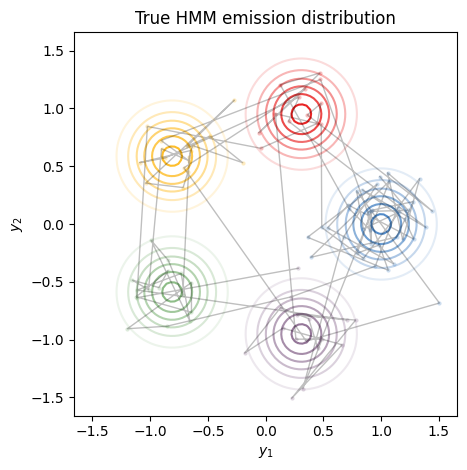

In [7]:
# Plot emissions and true_states in the emissions plane
plot_gaussian_hmm(hmm, true_params, train_emissions[0], train_true_states[0], 
                  title="True HMM emission distribution")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Visualize dynamics </h2>
<p> By plotting these states as a function of time, the interplay between descrete latent states, transition matrix mediated dynamics (Markov process) and the observations (or emissions) becomes more clear.
</div>

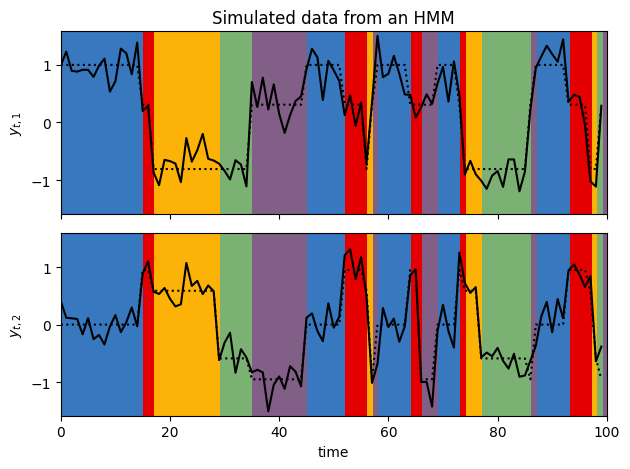

In [8]:
# Plot emissions vs. time with background colored by true state
plot_gaussian_hmm_data(hmm, true_params, train_emissions[0], train_true_states[0])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Write a helper function to perform leave-one-out cross-validation </h3>
    
<p> In previous days, we've seen the vitial importance of cross-validation as a saneity check on your data to avoid overfitting. Let's bring those principles in here.
    
<p> This function fits the data into _folds_ where each fold consists of all
but one of the training sequences. It fits the model to each fold in 
parallel, and then computs the log likelihood of the held-out sequence for
each fold. The average held-out log likelihood is what we will use for 
determining the number of discrete states.
</div>



In [9]:
def cross_validate_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(key=key, method='kmeans', emissions=train_emissions)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)
    ])
    
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_em(params, props, y_train, 
                                             num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_emissions)
    return val_lls.mean(), val_lls

In [35]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []
for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0)))
    
avg_val_lls, all_val_lls = tuple(zip(*results))

fitting model with 2 states
fitting model with 3 states
fitting model with 4 states
fitting model with 5 states
fitting model with 6 states
fitting model with 7 states
fitting model with 8 states
fitting model with 9 states


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b>  Plot up the average validation log-likelihood and discuss with your neighbor the implications of this curve shape? If you didn't know how many true states there where, how would you decide when to stop adding states? Will this lesson generalize to other types of data?
</div>

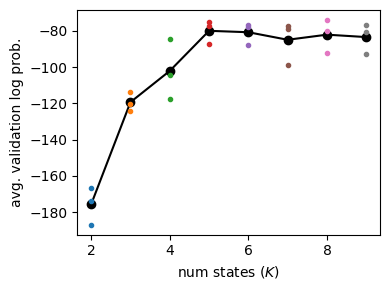

In [34]:
plt.figure(figsize = (4, 3))
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> How should we choose the right number of states? </h3>
    
<p> There's no right answer for how to choose the number of states, but reasonable heuristics include:
    
<ul> * picking $K$ that has the highest average validation log prob
<p> * picking $K$ where the average validation log prob stops increasing by a minimum amount
<p> * picking $K$ with a hypothesis test for increasing mean
    
<p> Here, we'll just choose the number of states with the highest average.
</div>


In [12]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_val_lls))]
print("best number of states:", best_num_states)

best number of states: 5


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Now let's fit our model with the best number of states? </h3>
    
<p> Using the number of states with the highest average, we can fit our Gaussian HMM with dynamax.
</div>

In [13]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
test_hmm = GaussianHMM(best_num_states, emission_dim, transition_matrix_stickiness=10.)
params, props = test_hmm.initialize(key=key, method="kmeans", emissions=train_emissions)
params, lps = test_hmm.fit_em(params, props, train_emissions, num_iters=100)

/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b>  Plot up the log-likelihood and compare it to the actual lp.
</div>

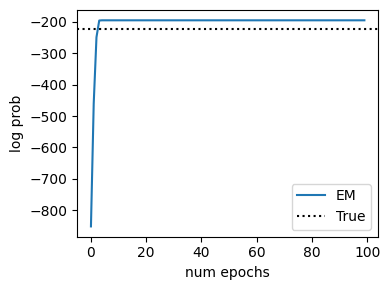

In [32]:
# Evaluate the log probability of the training data under the true parameters
true_lp = vmap(partial(hmm.marginal_log_prob, params))(train_emissions).sum()
true_lp += hmm.log_prior(params)

# Plot log probs vs num_iterations
offset = 0
plt.figure(figsize = (4, 3))
plt.plot(jnp.arange(len(lps)-offset), lps[offset:], label='EM')
plt.axhline(true_lp, color='k', linestyle=':', label="True")
plt.xlabel('num epochs')
plt.ylabel('log prob')
plt.legend()
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h3> Comparing EM with Gradient Descent </h3>
    
<p> EM is much faster than gradient descent in this use case because it....
    
</div>

In [15]:
key = jr.PRNGKey(0)
sgd_params, sgd_param_props = hmm.initialize(key)
sgd_key, key = jr.split(key)
sgd_params, sgd_losses = hmm.fit_sgd(sgd_params, 
                                     sgd_param_props, 
                                     train_emissions, 
                                     optimizer=optax.sgd(learning_rate=1e-7, momentum=0.9),
                                     batch_size=2, 
                                     num_epochs=400, 
                                     key=sgd_key)

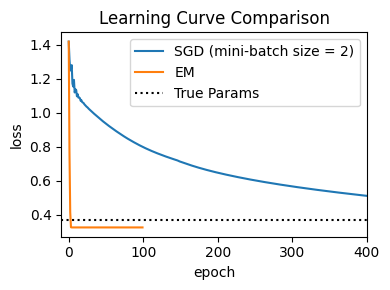

In [31]:
em_losses = -lps / train_emissions.size 

# Compute the loss if you used the parameters that generated the data
true_loss = vmap(partial(hmm.marginal_log_prob, params))(train_emissions).sum()
true_loss += hmm.log_prior(params)
true_loss = -true_loss / train_emissions.size

# Plot the learning curves
plt.figure(figsize = (4, 3))
plt.plot(sgd_losses*em_losses[0]/sgd_losses[0], label="SGD (mini-batch size = 2)")
plt.plot(em_losses, label="EM")
plt.axhline(true_loss, color='k', linestyle=':', label="True Params")
plt.legend()
plt.xlim(-10, 400)
plt.xlabel("epoch")
plt.ylabel("loss")
_ = plt.title("Learning Curve Comparison")
plt.tight_layout()

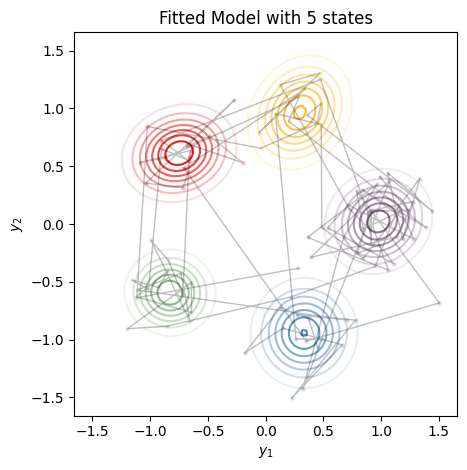

In [17]:
most_likely_states = test_hmm.most_likely_states(params, train_emissions[0])
plot_gaussian_hmm(test_hmm, params, train_emissions[0], most_likely_states, 
                  title=f"Fitted Model with {best_num_states} states", alpha=0.25)

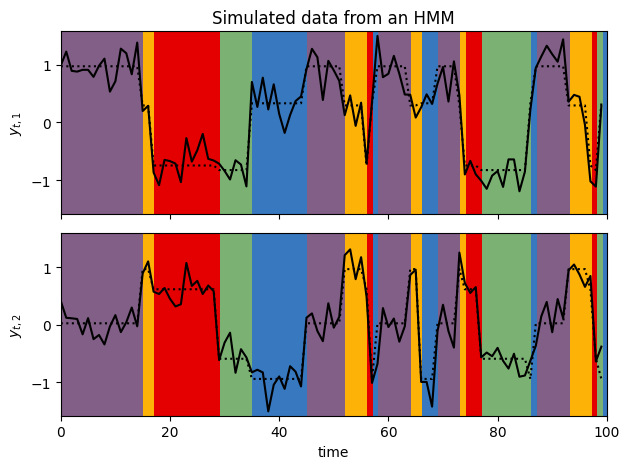

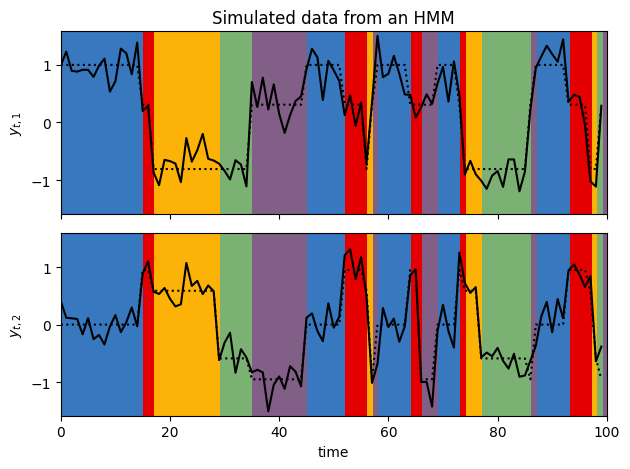

In [18]:
plot_gaussian_hmm_data(test_hmm, params, train_emissions[0], most_likely_states, xlim=(0, 100))
plot_gaussian_hmm_data(hmm, true_params, train_emissions[0], train_true_states[0])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b>  Compare the inferred states to the actual states by using the plot_gaussian_hmm_data() function for both the inferred and actual states. Discuss with your neighbors what you observe.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Automated state determination in Visual Behavior mice </h2>
<p> Let's take what we've done above and merge it with our work in the previous workshop to extract automated detection of latent states in engaged/disengaged mice in the visual behavior dataset.
</div>

In [19]:
from allensdk.brain_observatory.ecephys.behavior_ecephys_session import BehaviorEcephysSession

from utils import get_session, get_session_table, get_units_table, get_probes_table, get_channels_table

path_to_nwbs = '/root/capsule/data/visual_behavior_neuropixels/visual-behavior-neuropixels-0.4.0/behavior_ecephys_sessions/'

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Choose the same mice selected in the visual behavior dataset from Workshop 1.
</div>

In [20]:
example_sessions = [1139846596, 1124507277, 1069461581, ]

session_id = example_sessions[0]
session = get_session(session_id)

trial_metadata = session.trials

display(trial_metadata.head())

,start_time,stop_time,initial_image_name,change_image_name,is_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
0,27.66076,28.61154,im104_r,im104_r,False,NaN,False,False,[28.27695],NaN,NaN,0.0,False,False,False,False,True,False,NaN,0.95078
1,29.16146,30.88003,im104_r,im104_r,False,NaN,False,False,[30.56264],NaN,NaN,0.0,False,False,False,False,True,False,NaN,1.71857
2,31.41341,33.53196,im104_r,im104_r,False,NaN,False,False,"[32.7479, 32.94767, 33.21476]",NaN,NaN,0.0,False,False,False,False,True,False,NaN,2.11855
3,33.66560,36.08416,im104_r,im104_r,False,NaN,False,False,[35.76732],NaN,NaN,0.0,False,False,False,False,True,False,NaN,2.41856
4,36.66823,38.33614,im104_r,im104_r,False,NaN,False,False,[38.01908],NaN,NaN,0.0,False,False,False,False,True,False,NaN,1.66791


In [38]:
session.stimulus_presentations

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,is_image_novel,omitted,...,rewarded,spatial_frequency,start_frame,start_time,stimulus_block,stimulus_index,stimulus_name,end_time,temporal_frequency,trials_id
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,True,NaN,NaN,0.250212,75,0.0,im104_r,False,False,False,...,False,NaN,60,27.705472,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,27.955683,NaN,0
1,True,NaN,NaN,0.250212,120,1.0,im104_r,False,False,False,...,False,NaN,105,28.456107,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,28.706318,NaN,0
2,True,NaN,NaN,NaN,165,1.0,omitted,False,<NA>,True,...,False,NaN,150,29.206725,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,29.456928,NaN,1
3,True,NaN,NaN,0.250212,210,2.0,im104_r,False,False,False,...,False,NaN,195,29.957343,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,30.207555,NaN,1
4,True,NaN,NaN,0.250208,255,3.0,im104_r,False,False,False,...,False,NaN,240,30.707978,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,30.958187,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13398,False,NaN,NaN,0.250205,523499,1.0,im114_r,False,False,False,...,False,NaN,523484,8788.329652,5,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,8788.579857,NaN,672
13399,False,NaN,NaN,0.250206,523544,2.0,im114_r,False,False,False,...,False,NaN,523529,8789.080268,5,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,8789.330474,NaN,672
13400,False,NaN,NaN,0.250207,523589,3.0,im114_r,False,False,False,...,False,NaN,523574,8789.830889,5,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,8790.081096,NaN,672


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b>  Extract the licks data and the active stimulus presentations from the session under study (let's call them flashes).
</div>

In [39]:
licks = session.licks
flashes = session.stimulus_presentations[session.stimulus_presentations.active].copy()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> Replace individual licks with the starting timepoint of a lick bout.
</div>

In [40]:
lick_times = licks.timestamps.values
lick_intervals = np.concatenate([[np.inf], np.diff(lick_times)])
is_bout_start = lick_intervals > 3 * np.median(lick_intervals[1:])
bout_start_times = lick_times[is_bout_start]
flashes['licked'] = flashes.apply(
    lambda row: np.sum((bout_start_times > row["start_time"]) & \
                       (bout_start_times < row["start_time"] + 0.75)) > 0,
    axis=1,
)

Text(0.5, 0, 'flash index')

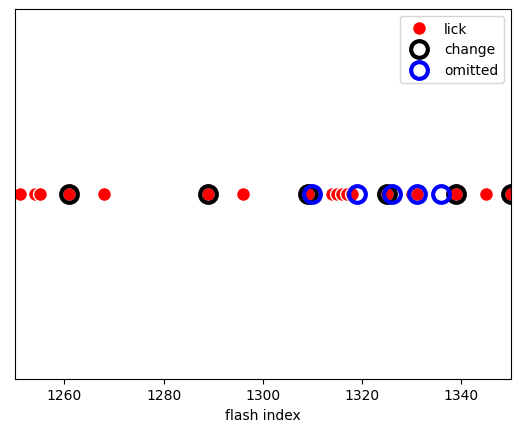

In [41]:
change_idxs = np.where(flashes.is_change)[0]
omitted_idxs = np.where(flashes.omitted)[0]
lick_idxs = np.where(flashes.licked)[0]
plt.plot(lick_idxs, np.ones_like(lick_idxs), 'ro', ms=10, mec='w', label="lick")
plt.plot(change_idxs, np.ones_like(change_idxs), 'o', mec='k', mfc='none', ms=12, mew=3, label="change")
plt.plot(omitted_idxs, np.ones_like(omitted_idxs), 'o', mec='b', mfc='none', ms=12, mew=3, label="omitted")
plt.xlim(1250, 1350)
plt.yticks([])
plt.legend()
plt.xlabel("flash index")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<p> We will now use the union of the flashes and the lick bouts to determine the False negative, True positive, False Positive, and True Negative rates across the session.
</div>

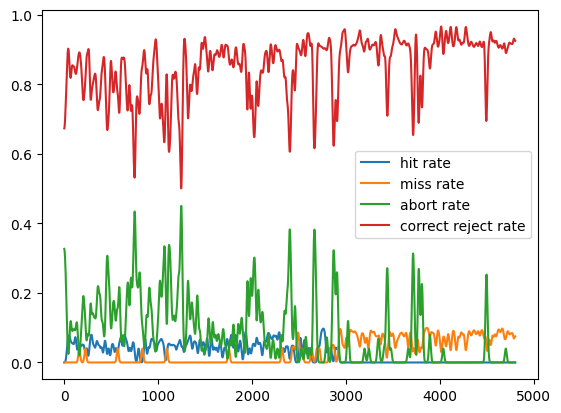

In [42]:
# Label licks as:
# - true positive (hits)
# - false negative (miss)
# - false positive (mostly abort)
# - true negative (correct reject)
tp = np.array(flashes.is_change & flashes.licked, dtype=float)
fn = np.array(flashes.is_change & ~flashes.licked, dtype=float)
fp = np.array(~flashes.is_change & flashes.licked, dtype=float)
tn = np.array(~flashes.is_change & ~flashes.licked, dtype=float)

# Smooth these over time with a Gaussian filter to estimate "rates"
from scipy.ndimage import gaussian_filter1d
sigma = 10
tpr = gaussian_filter1d(tp, sigma)
fnr = gaussian_filter1d(fn, sigma)
fpr = gaussian_filter1d(fp, sigma)
tnr = gaussian_filter1d(tn, sigma)

# Plot them
plt.plot(tpr, label="hit rate")
plt.plot(fnr, label="miss rate")
plt.plot(fpr, label="abort rate")
plt.plot(tnr, label="correct reject rate")
plt.legend()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b>  Recalling our previous manual determination on this session. Do you see any signals of the disengaged state? How can we amplify them by defining the precision and recall?
    
   Rather than looking at all four of these quantities, we often summarize them in terms of the _precision_ (here, the fraction of licks that were hits) and _recall_ (here, the fraction of changes that the mouse hit)
</div>

Text(0.5, 0, 'stimulus presentation')

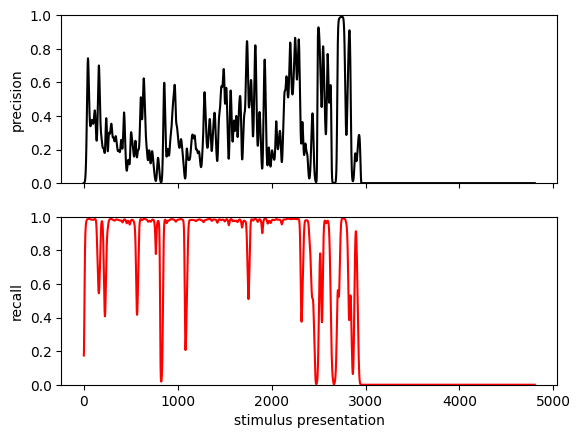

In [43]:
# Compute precision and recall rates
precision = tpr / (tpr + fpr + 1e-3)
recall = tpr / (tpr + fnr + 1e-3)

# Plot a smoothed estimate of the true positive (etc) rate over time
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(precision, 'k')
axs[0].set_ylabel("precision")
axs[0].set_ylim(0, 1)
axs[1].plot(recall, 'r')
axs[1].set_ylabel("recall")
axs[1].set_ylim(0, 1)
axs[1].set_xlabel("stimulus presentation")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Automated state determination in Visual Behavior mice </h2>

The idea behind this model is that the mouse's behavior varies with changes in its internal state. We don't directly observe this internal state (it's latent), but we can draw inferences about it based on the mouse's behavior. For example, if the mouse stops licking in response to stimulus changes, then we might infer that it has switched into an "inattentive" or "disenganged" state. The internal states we infer from behavior can offer clues for when we should look for changes in the underlying neural activity.

Let's formalize this with a hidden Markov model. Let 
- $y_t \in \{0,1\}$ specify whether or not the **mouse licked** on stimulus presentation $t$.
- $x_t \in \{-1,1\}$ specify whether or not the **stimulus changed** on stimulus presentation $t$.
- $z_t \in \{1, \ldots, K\}$ denote the **discrete internal state** of the mouse on stimulus presentation $t$.

We will model the relationship between licking ($y_t$) and stimulus changes ($x_t$) as a function of the internal state ($z_t$) with the following conditional distribution,
\begin{align*}
\Pr(y_t = 1 \mid x_t, z_t) &= \sigma(\alpha_{z_t} x_t + \beta_{z_t})
\end{align*}
where $\sigma(u) = \frac{1}{1+e^{-u}}$ is the _logistic function_, and $(\alpha_k, \beta_k)$ are parameters of a _logistic regression_. 

The logistic function is a "squashing" nonlinearity,
<div>

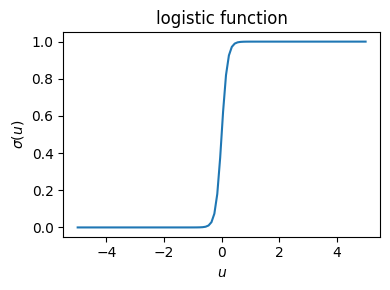

In [44]:
u = np.linspace(-5, 5, 100)
beta = 0.1
plt.figure(figsize = (4, 3))
plt.plot(u, 1 / (1 + np.exp(-u/beta)))
plt.xlabel("$u$")
plt.ylabel("$\sigma(u)$")
plt.title("logistic function")
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Intuitively, when the linear function $\alpha_{z_t} x_t + \beta_{z_t}$ is much greater than zero, the probability of the mouse licking is high. When the linear function is much less than zero, the lick probability is low. 

Thus, $\alpha_k$ determines the mouse's _sensitivity_: how much a change in stimulus alters the mouse's lick probability in state $z_t = k$. Likewise, $\beta_k$ determines the mouse's _bias_ of the mouse toward licking or not licking in state $z_t = k$. 

We are interested in whether the sensitivity and bias of the mouse are changing over the course of the session. If they are, it might signal a change in internal state.

To do so, we'll fit a `LogisticRegressionHMM`, i.e. an HMM where each state corresponds to a different logistic regression mapping stimulus features to behavior.

<div>

In [45]:
from dynamax.hidden_markov_model import LogisticRegressionHMM

In [46]:
# Encode stimulus change as +1 and no change as- 1
licked = flashes.licked.values.astype(int)
pm1 = lambda x: -1 + 2 * x
is_change = pm1(flashes.is_change.values.astype(float))

# For this model, it's important that the data is converted into a *JAX* array
y = jnp.array(licked)
X = jnp.column_stack([is_change])
X_names = ["is change"]
n_features = X.shape[1]

# Split the data into equal length batches
n_batches = 8
n_flashes = len(y) - (len(y) % n_batches)
batched_y = y[:n_flashes].reshape(n_batches, -1)
batched_X = X[:n_flashes].reshape(n_batches, -1, n_features)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    First, we should complete a cross-validation to determine a useful number of states to look at.
<div>

In [47]:
avg_test_log_probs = []
for num_states in range(2, 11):
    print("num states: ", num_states)
    
    test_log_probs = []
    for batch in trange(n_batches):
        # Extract all but this batch for training
        train_X = np.concatenate([batched_X[:batch], batched_X[batch+1:]])
        train_y = np.concatenate([batched_y[:batch], batched_y[batch+1:]])

        # Make an HMM
        hmm = LogisticRegressionHMM(num_states, n_features)
        params, param_props = hmm.initialize(jr.PRNGKey(1234))
        
        # Fix the initial probabilities and transition matrix
        #param_props.initial.probs.value = jnp.ones(num_states) / num_states
        #param_props.initial.probs.trainable = True

        #param_props.transitions.transition_matrix.value = 0.99 * jnp.eye(num_states) + 0.01 * jnp.ones((num_states, num_states)) / num_states
        #param_props.transitions.transition_matrix.trainable = True
        
        # Fit the model
        params, lps = hmm.fit_em(params, param_props, jnp.array(train_y), inputs =  np.array(train_X), num_iters=1000)
        
        # Evaluate the log probability on held out data
        test_lp = hmm.marginal_log_prob(params, jnp.array(batched_y[batch]), 
                                        jnp.array(batched_X[batch]))
        test_log_probs.append(test_lp)
       
    # Store the average test log prob
    avg_test_log_probs.append(np.mean(test_log_probs))
        

num states:  2


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  3


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  4


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  5


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  6


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  7


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  8


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  9


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  10


  0%|          | 0/8 [00:00<?, ?it/s]

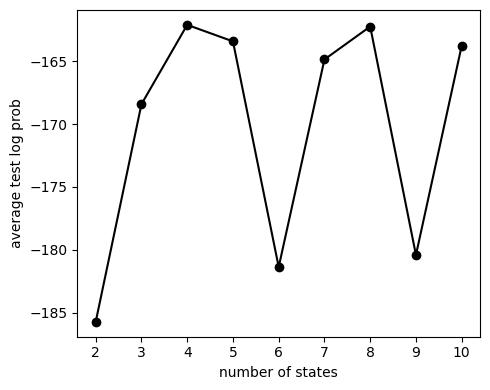

In [53]:
plt.figure(figsize = (5, 4))
plt.plot(np.arange(2, 11), avg_test_log_probs, '-ko')
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task:</b>  Choose the best number of states and discuss with your neighbors why the shape of the cross-validation could be the way it is? Are there any other metrics you could use to decide on the number of states? Does this automated detection 
</div>

In [49]:
num_states = 3
hmm = LogisticRegressionHMM(num_states, n_features)
params, param_props = hmm.initialize(jr.PRNGKey(1234))
# Fix the initial probabilities and transition matrix
param_props.initial.probs.value = jnp.ones(num_states) / num_states
param_props.initial.probs.trainable = True

param_props.transitions.transition_matrix.value = 0.9 * jnp.eye(num_states) + 0.1 * jnp.ones((num_states, num_states)) / num_states
param_props.transitions.transition_matrix.trainable = True

# Now call fit, again casting to JAX arrays
params, lps = hmm.fit_em(params, param_props, jnp.array(batched_y), inputs = np.array(batched_X), num_iters=1000)

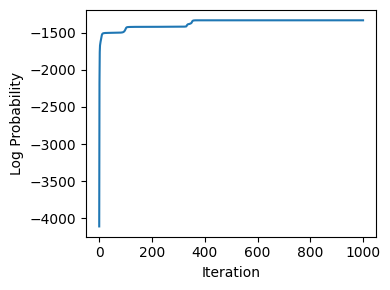

In [54]:
plt.figure(figsize = (4, 3))
plt.plot(lps)
plt.xlabel("Iteration")
plt.ylabel("Log Probability")
plt.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's plot up the inferred states by conducting inference with our fit model on the observed emissions.
<div>

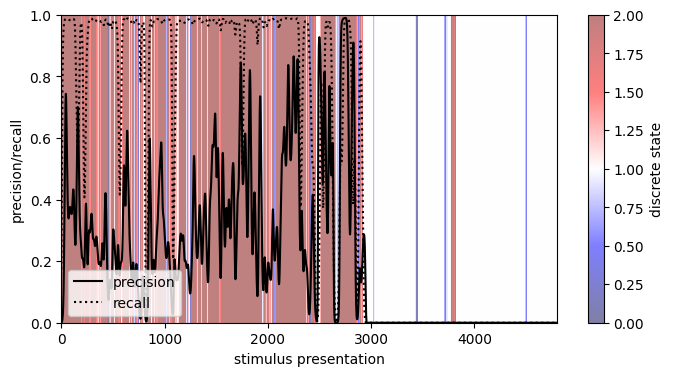

In [55]:
# Find the most likely discrete states given the learned model parameters
most_likely_states = hmm.most_likely_states(params, y, X)

# Overlay the precision and recall curves on top of the inferred states
plt.figure(figsize=(8, 4))
plt.imshow(most_likely_states[None, :], alpha=0.5, 
           extent=(0, len(y), 0, 1), aspect="auto", cmap='seismic')
plt.plot(precision, '-k', label="precision")
plt.plot(recall, ':k', label="recall")
plt.ylim(0, 1)
plt.ylabel("precision/recall")
plt.xlabel("stimulus presentation")
plt.legend(loc="lower left")

cb = plt.colorbar()
cb.set_label("discrete state")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Next, we will look at the posterior distribution as a probability of of being in each latent state at each time.
<div>

Text(0.5, 0, 'stimulus presentation')

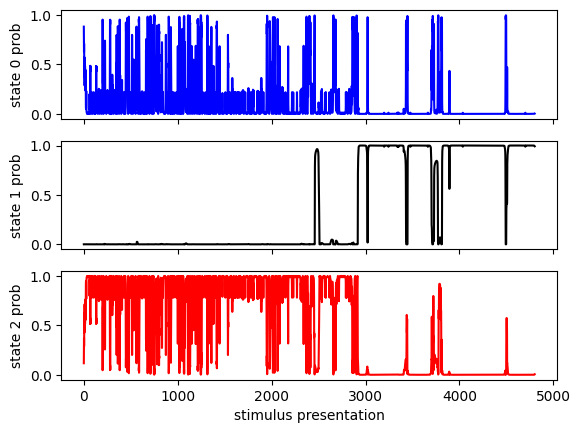

In [56]:
# Find the posterior distribution over states
posterior = hmm.smoother(params, y, X)

# Compare the true and inferred states
fig, axs = plt.subplots(hmm.num_states, 1, sharex=True)
col = ['b', 'k', 'r']
for k, ax in enumerate(axs):
    ax.plot(posterior.smoothed_probs[:, k], col[k])
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("state {} prob".format(k))
plt.xlabel("stimulus presentation")

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
In this workshop, we have introduced you some tools spanning conceptual (HMMs, ExpectationMaximization Algorithms) to software (dynamax, jax). While part of this workshop was focused on tooling, we hope that you also built a complementary appreciation for behavior states and some of the computational tools for inferring them directly from data.
<div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem/Project Idea:</b> You can think of the inferred behavioral states as features that have been derived from the behavioral data. These features are prime candidates to correlate with neural measurements. Do you think the neural responses to flashes/changes/omissions will differ from behavioral state to the next? 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem/Project Idea:</b> Likewise, we can correlate the inferred behavioral states with other aspects of the animal's behavior. Have we simply constructed a fancy way of extracting running speed and/or pupil size?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem/Project Idea:</b> How do the behavioral states differ across mice or sessions? Are some mice better performers than others?
</div>